In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

DATA_DIR = "/home/nihil/Scrivania/hyser_dataset"
FS_EMG = 2048  # sampling frequency
MAX_COMP = 150  # target number of components

SEED = 42

# Decomposition of sEMG Signals and Gesture Classification with SNNs

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, since the muscle fibers act as a low-pass filter, the resulting sEMG signal is a convolutive mixture of the MUAPs ([Holobar et al.](https://ieeexplore.ieee.org/document/4291854)):

$x_i(k)=\sum_{l=0}^{L-1} \sum_{j=1}^N h_{ij}(l)s_j(k-l)+n_i(k);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{A}$ with size $L$ and the actual spike trains $\mathbf{S}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) adapted FastICA in order to address convolutive mixtures.

## 2. Hyser dataset
This dataset contains the sEMG recordings of 20 subjects, acquired while they were performing a certain task. In particular, the dataset is divided into 5 subsets, based on the task performed:

- **PR**: subjects were instructed to perform 34 hand gestures.
- **MVC**: subjects were instructed to perform their maximal voluntary isometric contraction.
- **1 DoF**: subjects were instructed to perform isometric contractions of each single finger.
- **N DoF**: subjects were instructed to perform isometric contractions of a combination of multiple fingers.
- **Random**: subjects were allowed to randomly perform isometric contractions of muscles corresponding to any combination of fingers with any force trajectory.

The sEMG data were collected using 4 arrays of 64 electrodes each (264 in total), with a sampling rate of 2048 Hz. The ground truth force trajectories of the five fingers were acquired using five separate sensor-amplifier pairs with a sampling rate of 100 Hz.

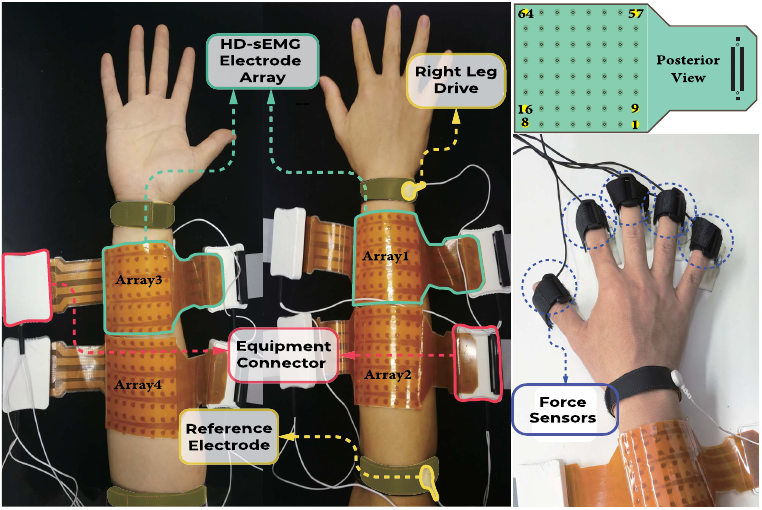

In particular, the first two arrays recorded the activity of the extensor muscle, whereas the remaining two arrays recorded the activity of the flexor muscle.

## 3. Decomposition - Training

For training the decomposition model, we'll test three strategies:

- train on NDoF signals and test on PR signals;
- train and test on both muscle groups or on the extensor only;
- train and test directly on PR signals.

### 3a. NDoF-full
Let's focus on the NDoF dataset: for each subject, we have

- 2 recording sessions;
- 15 tasks (one per combination of fingers);
- 2 trials;

resulting in 60 sEMG signals with 256 channels (128 for the extensor muscle group and 128 for the flexor muscle group).

For instance, let's visualize the first 15 channels of the sEMG signal for the 1st task, namely the isometric contraction of thumb + index (first subject, first session, first trial).

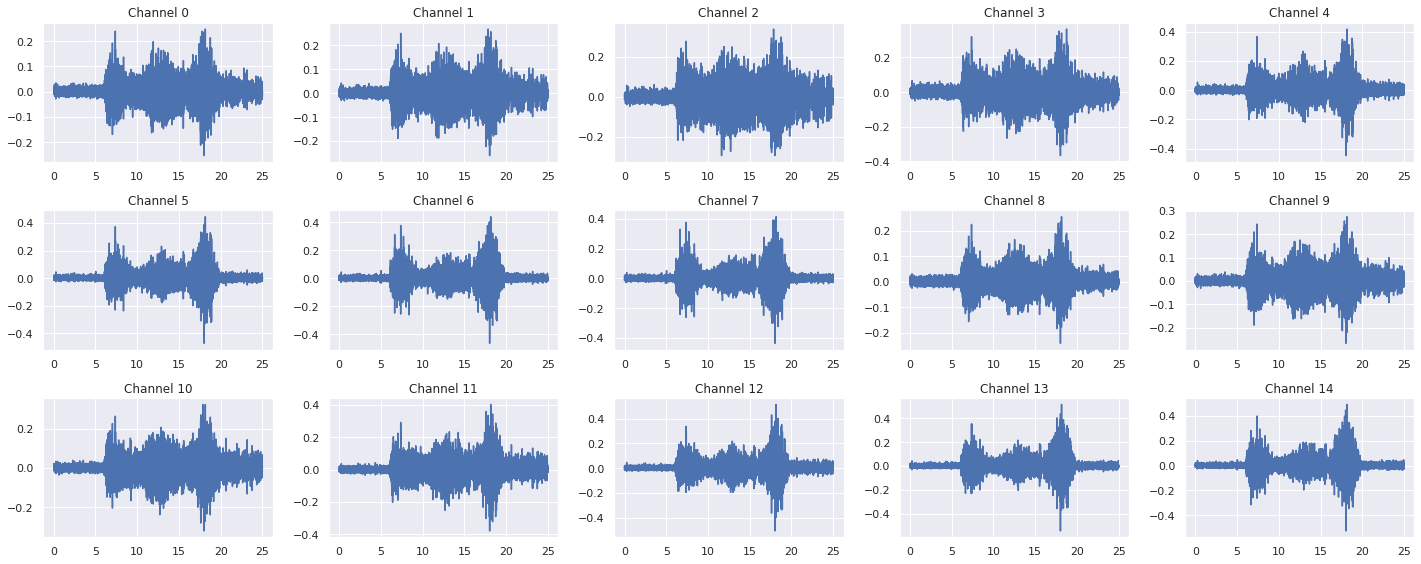

In [2]:
emg_train = semg_bss.hyser.load_ndof(DATA_DIR, subject=1, session=1, combination=1, trial=1, sig_type="preprocess")

semg_bss.plot_signal(emg_train[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 8))

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding delayed copies, resulting in $f_e \times M$ channels (where $M$ is the n. of channels in the original signal). In particular, we set $f_e=1000/M\approx4$.

Then, the extended signal is centered and whitened via eigenvalue decomposition.

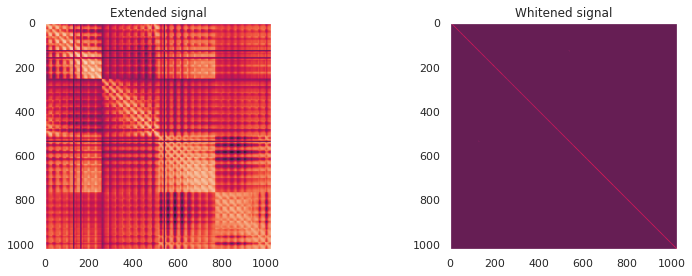

In [3]:
f_e = 4
emg_ext = semg_bss.preprocessing.extend_signal(emg_train, f_e)
emg_center = semg_bss.preprocessing.center_signal(emg_ext)
emg_white, _ = semg_bss.preprocessing.whiten_signal(emg_center)

semg_bss.plot_sub(
    sig_list=[emg_ext, emg_white],
    plot_fn=semg_bss.plot_correlation,
    title_list=["Extended signal", "Whitened signal"],
    n_cols=2,
    fig_size=(12, 4)
)

The logic behind FastICA and source improvement is encapsulated inside the `EmgSeparator` class: let's create one using $100$ target components and $f_e=4$.

In [4]:
emg_separator_a = semg_bss.EmgSeparator(
    max_comp=MAX_COMP,
    fs=FS_EMG,
    f_e=f_e,
    seed=SEED
)

Let's train the instance on the un-whitened sEMG signal.

Extracted 20 MUs.


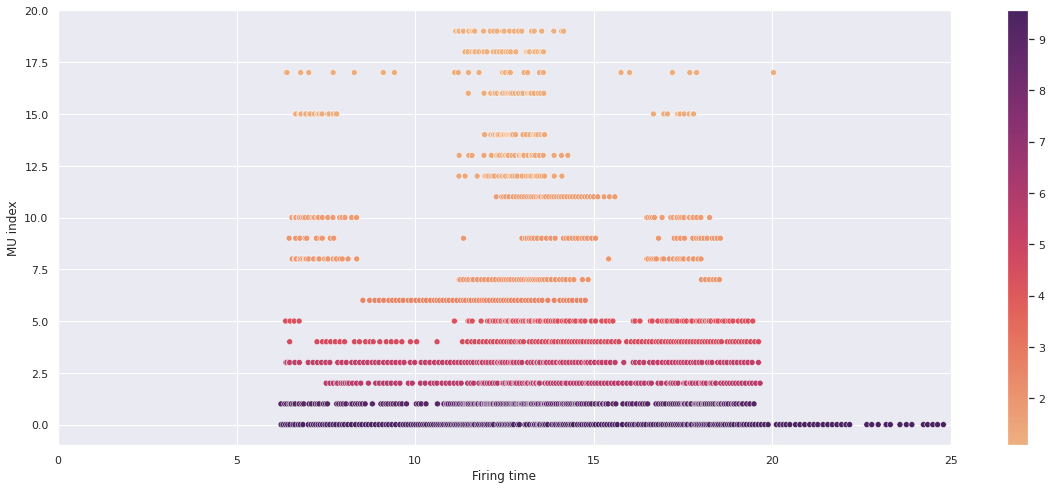

In [5]:
# Train instance on the given signal
firings = emg_separator_a.fit_transform(emg_train)
print(f"Extracted {emg_separator_a.n_mu} MUs.")
# Plot it
semg_bss.raster_plot(firings, sig_len=25, fig_size=(20, 8))

### 3b. NDoF-extensor
Now let's repeat the process for the extensor muscle group only.

Extracted 73 MUs.


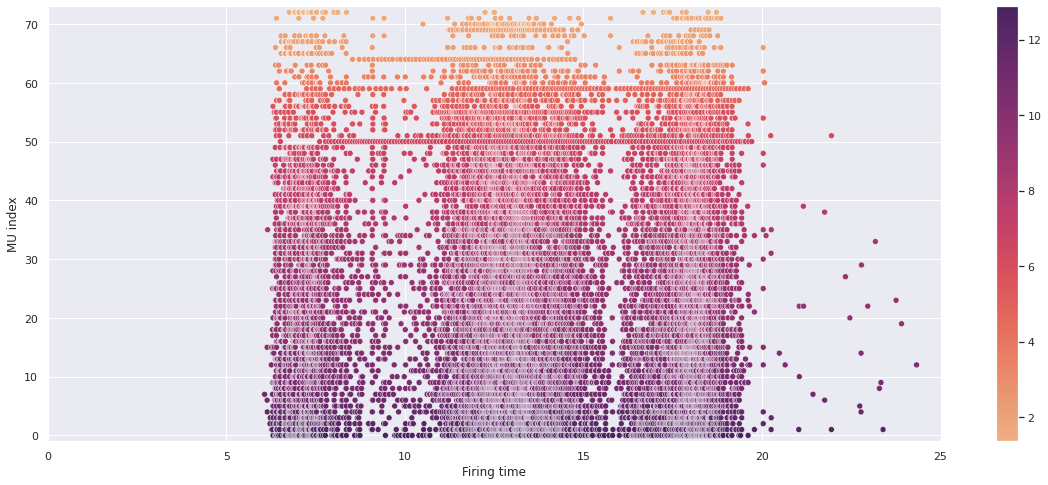

In [6]:
emg_separator_b = semg_bss.EmgSeparator(max_comp=MAX_COMP, fs=FS_EMG, f_e=f_e, seed=SEED)

# Train instance on the given signal
firings = emg_separator_b.fit_transform(emg_train[:128])
print(f"Extracted {emg_separator_b.n_mu} MUs.")
# Plot it
semg_bss.raster_plot(firings, sig_len=25, fig_size=(20, 8))

### 3c. PR-full

Let's focus on the PR dataset: for each subject, we have

- 2 recording sessions;
- 34 tasks (one per gesture);
- 2 trials;
- 3 dynamic tasks (1 s) and 1 maintenance task (4 s).

In particular, we're interested in the gesture thumb + index (the n. 12), and in the gesture of thumb and index alone (n. 1 and n. 2, respectively).

For instance, let's visualize the first 15 channels of the sEMG signal for the 12th gesture, namely the extension of thumb + index (first subject, first session, first trial).

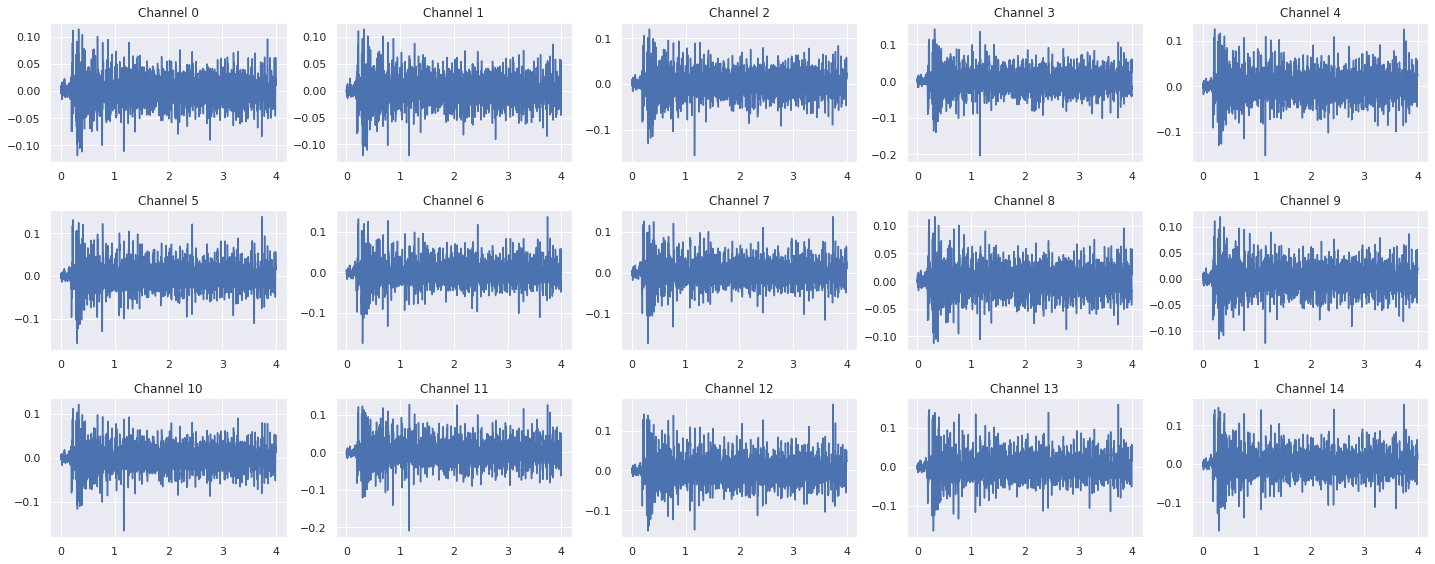

In [7]:
emg_train = semg_bss.hyser.load_pr(DATA_DIR, gesture=12, subject=1, session=1, task=1, trial=1, task_type="maintenance", sig_type="preprocess")

semg_bss.plot_signal(emg_train[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 8))

Extracted 11 MUs.


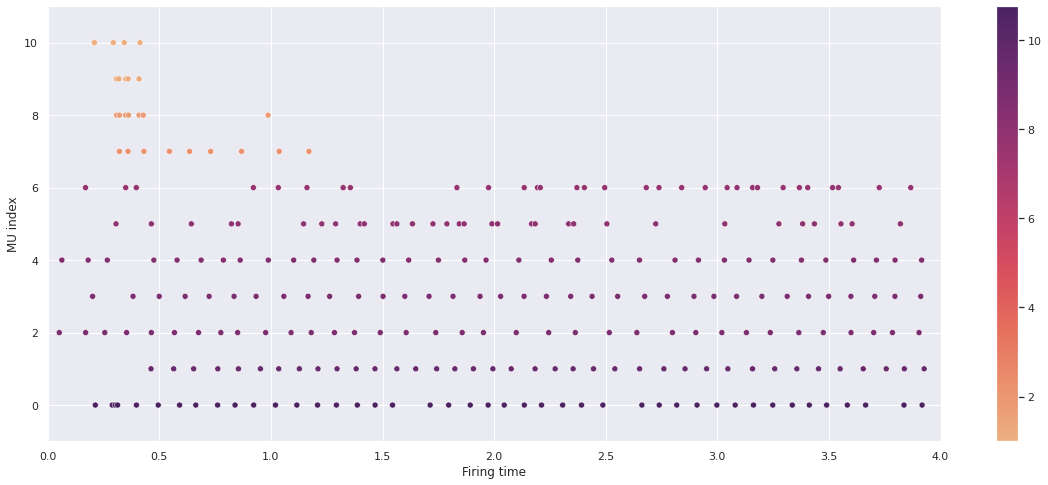

In [8]:
emg_separator_c = semg_bss.EmgSeparator(
    max_comp=MAX_COMP,
    fs=FS_EMG,
    f_e=f_e,
    seed=SEED
)

# Train instance on the given signal
firings = emg_separator_c.fit_transform(emg_train)
print(f"Extracted {emg_separator_c.n_mu} MUs.")
# Plot it
semg_bss.raster_plot(firings, sig_len=4, fig_size=(20, 8))

### 3d. PR-extensor
Now let's repeat the process for the extensor muscle group only.

Extracted 10 MUs.


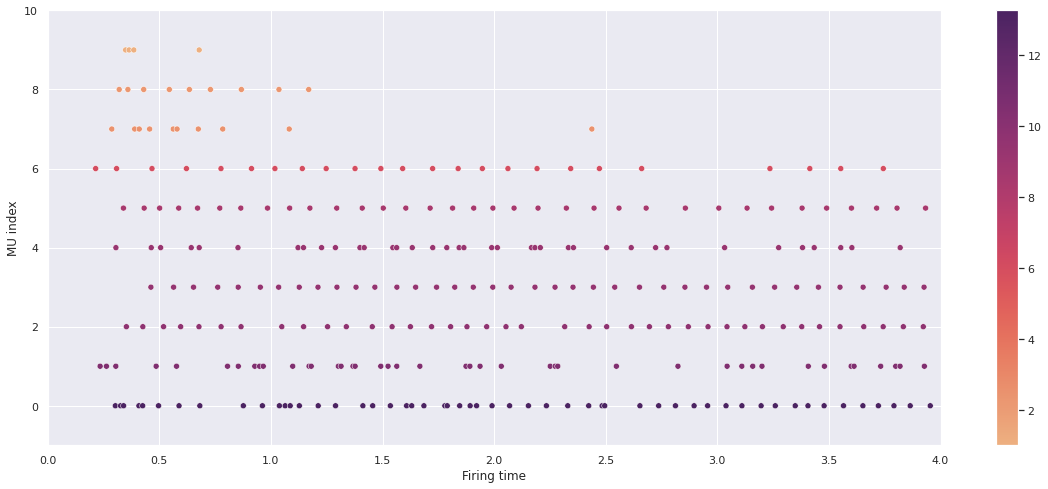

In [9]:
emg_separator_d = semg_bss.EmgSeparator(max_comp=MAX_COMP, fs=FS_EMG, f_e=f_e, seed=SEED)

# Train instance on the given signal
firings = emg_separator_d.fit_transform(emg_train[:128])
print(f"Extracted {emg_separator_d.n_mu} MUs.")
# Plot it
semg_bss.raster_plot(firings, sig_len=4, fig_size=(20, 8))

## 4. Decomposition - Test

We can test the decomposition model on signals from the PR dataset concerning thumb and index extensions. In particular, the PR dataset includes:

- maintenance signals (4 seconds);
- dynamic signals (1 second).

We'll focus on the maintenance signals, since it's easier to inspect visually.

Let's load the maintenance signal for the thumb.

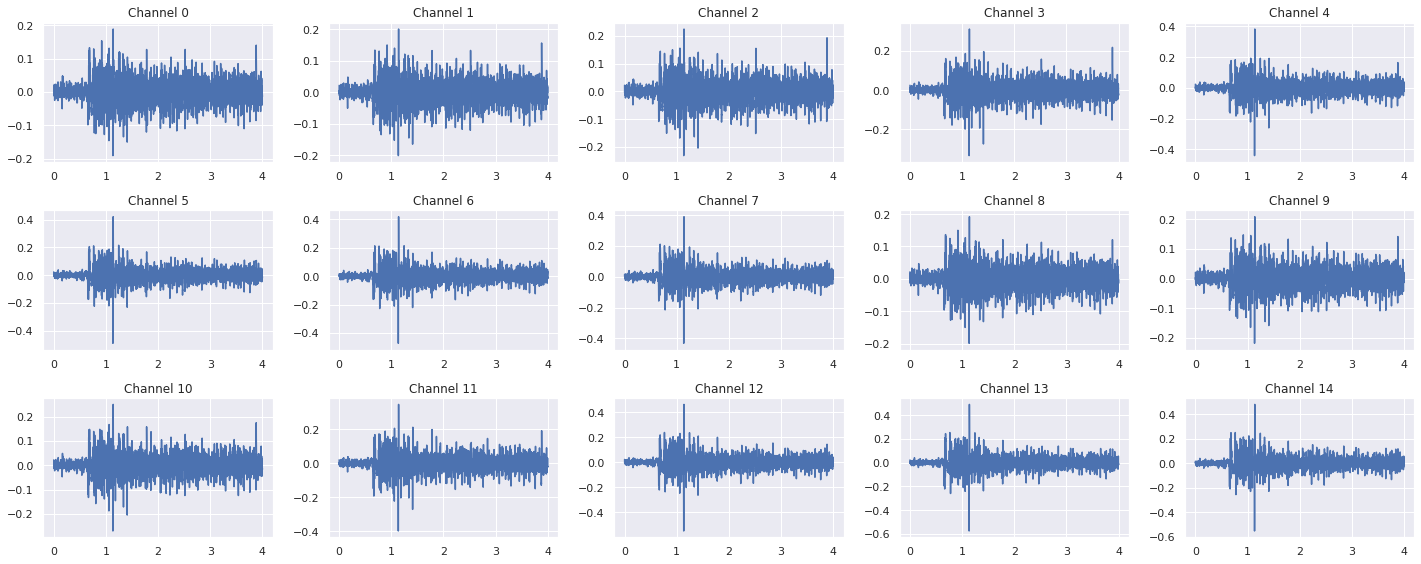

In [10]:
emg_pr1 = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="maintenance",
    gesture=1,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
semg_bss.plot_signal(emg_pr1[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 8))

Let's load the maintenance signal for the index.

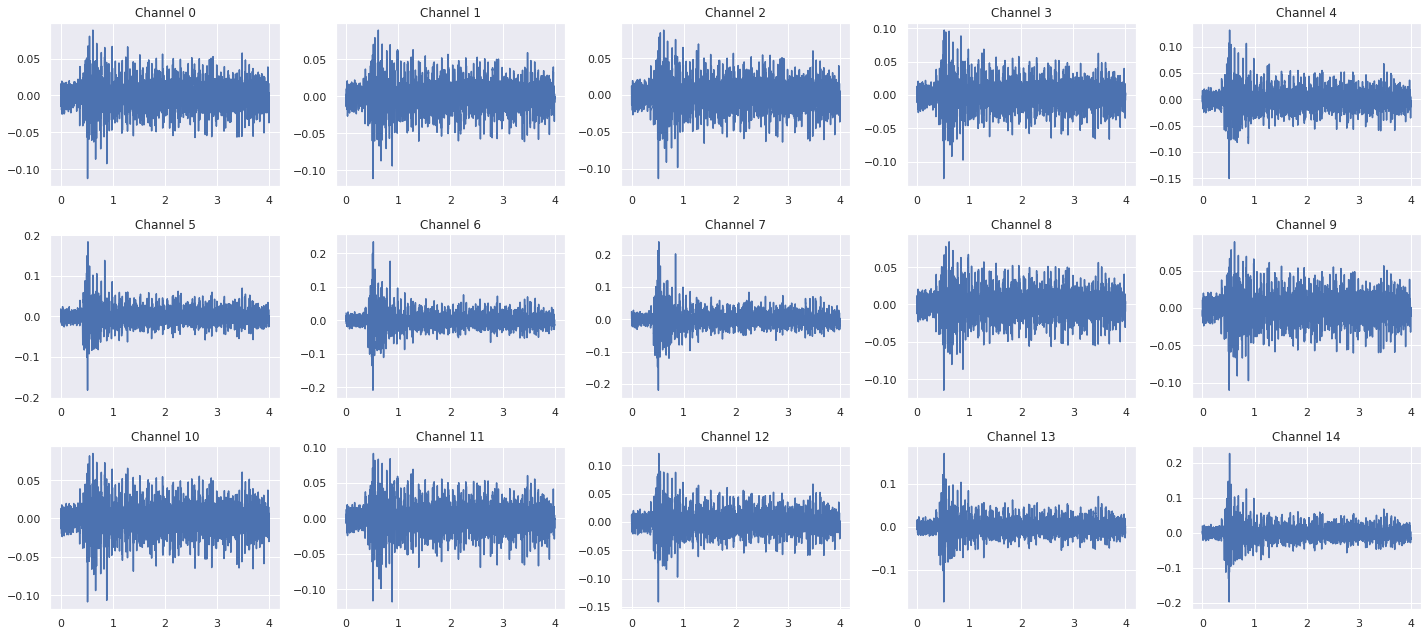

In [11]:
emg_pr2 = semg_bss.hyser.load_pr(
    DATA_DIR,
    task_type="maintenance",
    gesture=2,
    subject=1,
    session=1,
    task=1,
    trial=1,
    sig_type="preprocess"
)
semg_bss.plot_signal(emg_pr2[:15], fs=FS_EMG, n_cols=5, fig_size=(20, 9))

### 4a. NDoF-full
Let's decompose the two maintenance signals with the model trained on the full NDoF signal.

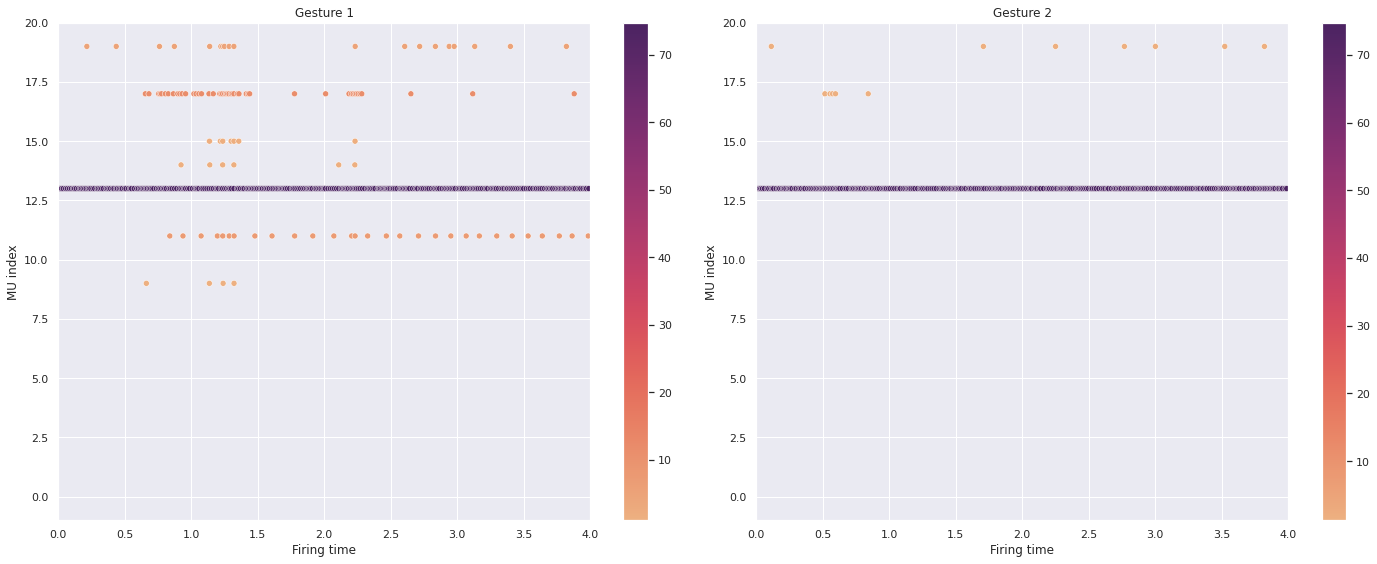

In [12]:
firings_pr1 = emg_separator_a.transform(emg_pr1)
firings_pr2 = emg_separator_a.transform(emg_pr2)

semg_bss.plot_sub(sig_list=[firings_pr1, firings_pr2], plot_fn=semg_bss.raster_plot, title_list=["Gesture 1", "Gesture 2"], n_cols=2, fig_size=(20, 8), sig_len=4)

### 4b. NDoF-extensor
Let's decompose the two maintenance signals with the model trained on the NDoF signal with the extensor muscle group only.

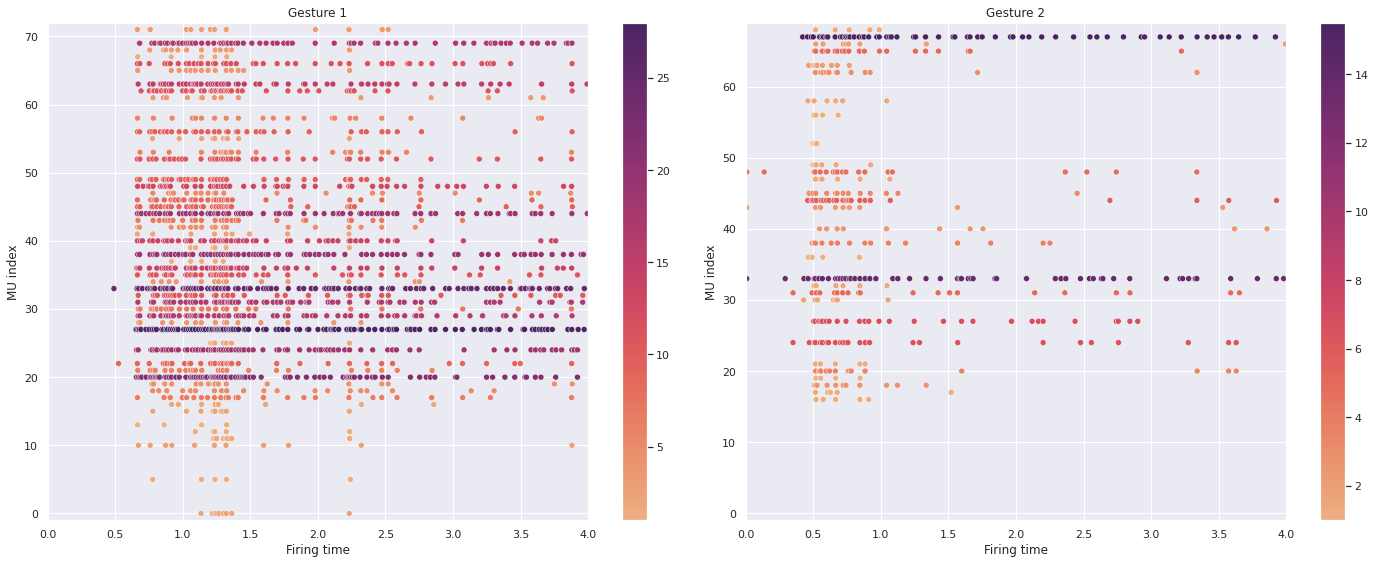

In [13]:
firings_pr1 = emg_separator_b.transform(emg_pr1[:128])
firings_pr2 = emg_separator_b.transform(emg_pr2[:128])

semg_bss.plot_sub(sig_list=[firings_pr1, firings_pr2], plot_fn=semg_bss.raster_plot, title_list=["Gesture 1", "Gesture 2"], n_cols=2, fig_size=(20, 8), sig_len=4)

### 4c. PR-full
Let's decompose the two maintenance signals with the model trained on the full PR signal.

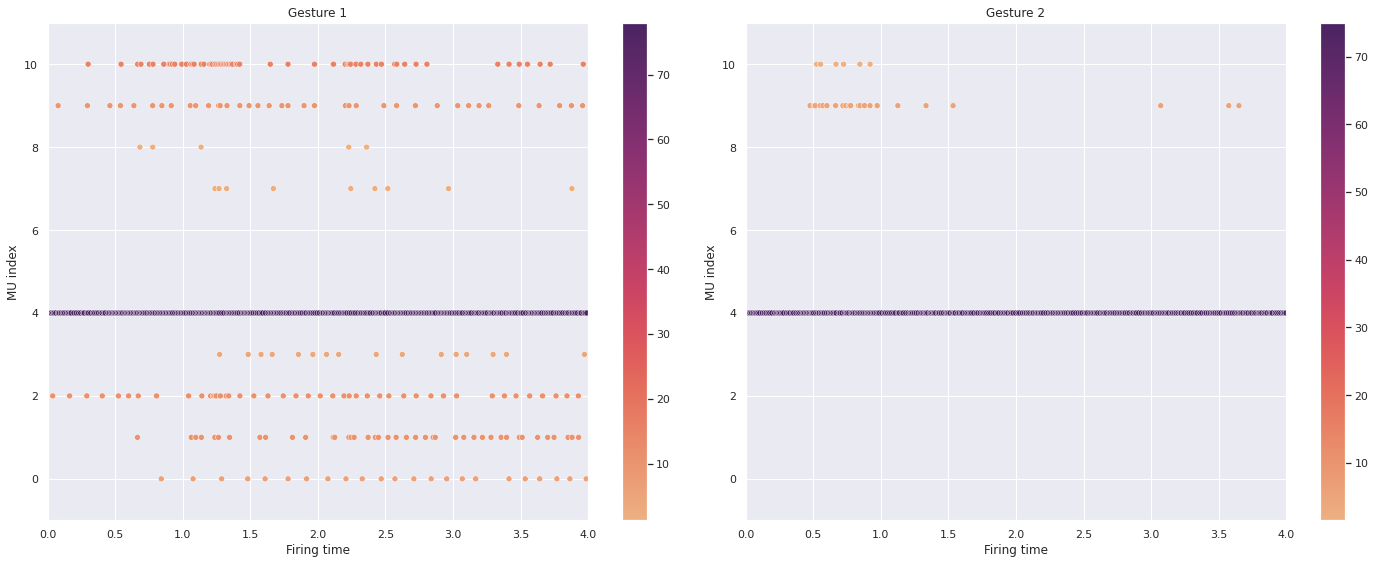

In [14]:
firings_pr1 = emg_separator_c.transform(emg_pr1)
firings_pr2 = emg_separator_c.transform(emg_pr2)

semg_bss.plot_sub(sig_list=[firings_pr1, firings_pr2], plot_fn=semg_bss.raster_plot, title_list=["Gesture 1", "Gesture 2"], n_cols=2, fig_size=(20, 8), sig_len=4)

### 4d. PR-extensor
Let's decompose the two maintenance signals with the model trained on the PR signal with the extensor muscle group only.

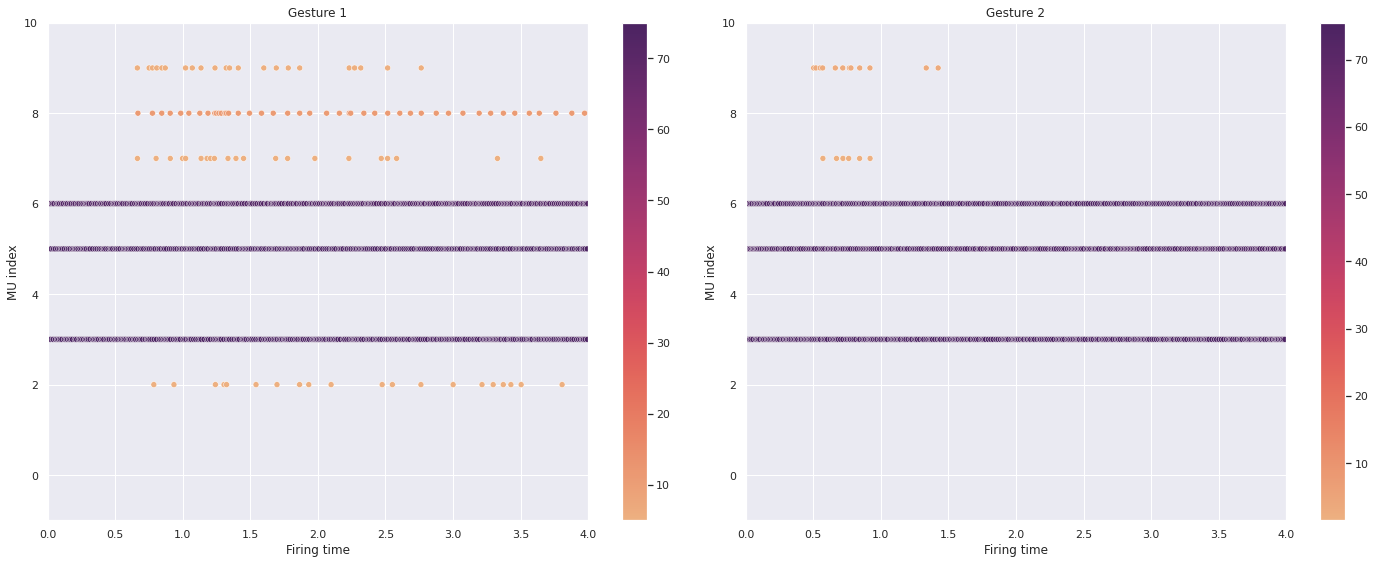

In [15]:
firings_pr1 = emg_separator_d.transform(emg_pr1[:128])
firings_pr2 = emg_separator_d.transform(emg_pr2[:128])

semg_bss.plot_sub(sig_list=[firings_pr1, firings_pr2], plot_fn=semg_bss.raster_plot, title_list=["Gesture 1", "Gesture 2"], n_cols=2, fig_size=(20, 8), sig_len=4)